# DeePC Implementation

### Packages

In [1603]:
import osqp
import cvxpy as cp
import numpy as np

import scipy as sp
from scipy import sparse

import matplotlib.pyplot as plt
from scipy.linalg import hankel

%matplotlib inline
%reload_ext autoreload
%autoreload 

from DeePC import DeePC

[autoreload of deepc failed: Traceback (most recent call last):
  File "/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 273, in check
    superreload(m, reload, self.old_objects)
  File "/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 471, in superreload
    module = reload(module)
  File "/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/importlib/__init__.py", line 168, in reload
    raise ModuleNotFoundError(f"spec not found for the module {name!r}", name=name)
ModuleNotFoundError: spec not found for the module 'deepc'
]
[autoreload of deepc failed: Traceback (most recent call last):
  File "/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 273, in check
    superreload(m, reload, self.old_objects)
  File "/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/IPython/extensions/autoreload.py", l

## Recht system

In [1604]:
A = np.array([[1.01, 0.01, 0.00], # A - State-space matrix
              [0.01, 1.01, 0.01], 
              [0.00, 0.01, 1.01]]) 
B = np.eye(3) # B - State-space matrix
C = np.eye(3) # C - State-space matrix
D = np.zeros([3,3]) # D - State-space matrix

n = A.shape[0] # n = number of states
m = B.shape[1] # m = number of inputs
p = C.shape[0] # p = number of output
q = m+p # q = number of i/o variables

Tini = 4                                   # Past time horizon                                           
Tf = 10                                     # Future time horizon         
T = (m+1)*(Tini + Tf + n) - 1                            


## Data Collection

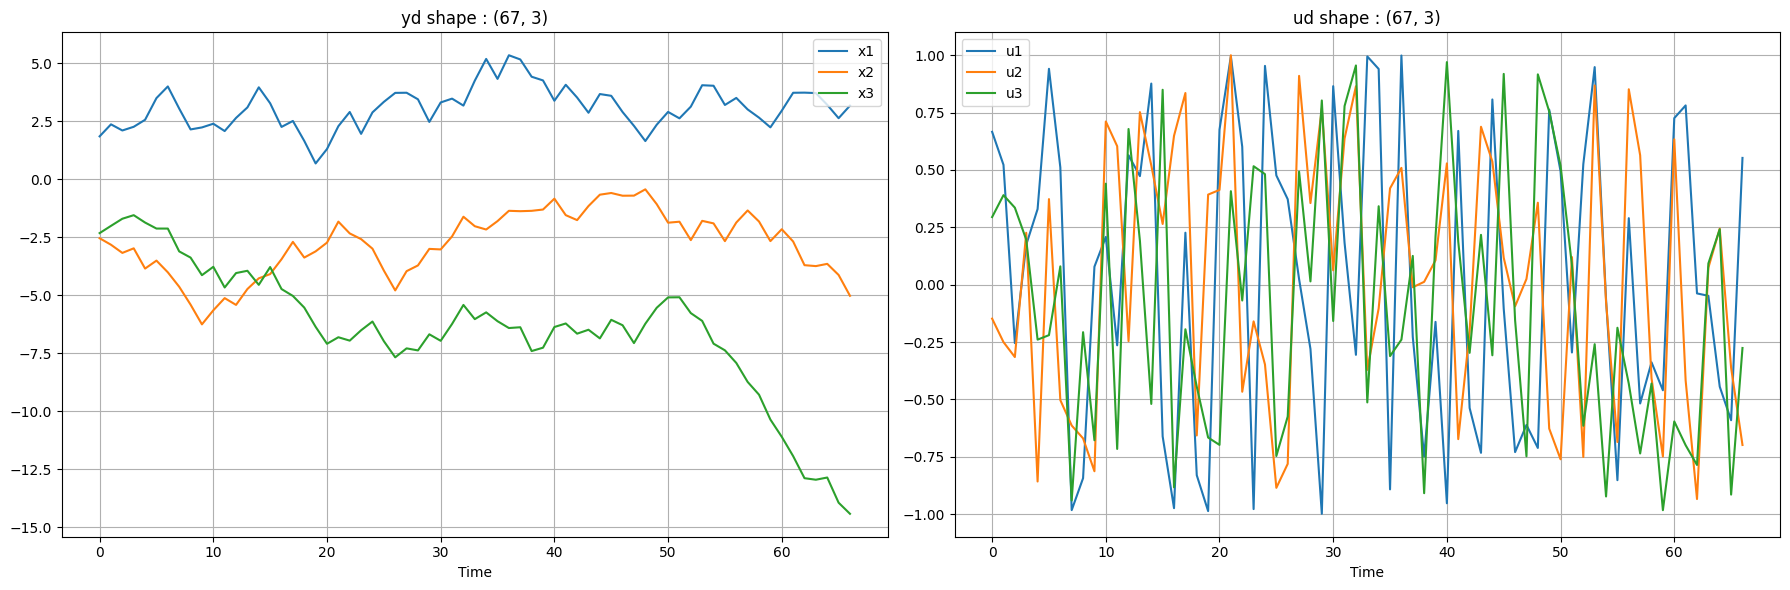

In [1605]:
ud = []
yd = []
x = np.random.uniform(low=-3, high=3, size=(m,))
for i in range(T):
   u = np.random.uniform(low=-1, high=1, size=(m,)) # Random input
   x = A@x + B@u
   y = C@x + D@u
   ud.append(u)
   yd.append(y+ np.random.randn(p,)*0.02)
ud = np.array(ud)
yd = np.array(yd)

# print(f'ud shape : {ud.shape}, yd shape : {yd.shape}')
plt.rcParams["figure.figsize"] = (18,6)
plt.subplot(1,2,1)
plt.plot(range(0,T), yd, label=['x1', 'x2', 'x3'])
plt.legend(loc="upper right")
plt.xlabel('Time')
plt.title(f"yd shape : {yd.shape}")
plt.grid('on')
plt.tight_layout()

plt.subplot(1,2,2)
plt.plot(range(0,T), ud, label=['u1', 'u2', 'u3'])
plt.legend(loc="upper left")
plt.xlabel('Time')
plt.title(f"ud shape : {ud.shape}")
plt.grid('on')
plt.tight_layout()

plt.show()

ud = ud.reshape((T*m,))
yd = yd.reshape((T*p,))

In [1606]:
u_ini = ud[:m*Tini].reshape((Tini*m,))
y_ini = yd[:p*Tini].reshape((Tini*p,))
y_constraints = np.kron(np.ones(Tf), np.array([4.2,0.2,4.2]))
u_constraonts = np.kron(np.ones(Tf), np.array([5,5,5]))
R = np.eye(m)*0.1
Q = np.eye(p)*10
ref = np.array([-4,0,4])
r = np.kron(np.ones(Tf), ref)

controller = DeePC(
    ud=ud, yd=yd, y_constraints=y_constraints, u_constraints=u_constraonts,
    N=Tf, Tini=Tini, n=n, T=T, p=p, m=m, Q=Q, R=R
)
controller.setup(ref=r, u_ini=u_ini, y_ini=y_ini, lam_y=0.5)

In [1607]:
T = 200
uT = [*u_ini]
yT = [*y_ini]

for i in range(0,T):
    print(i)
    action = controller.solve()
    obs = A@y_ini[-p:] + action
    yT = np.append(yT, obs + np.random.randn(p,)*0.01)
    uT = np.append(uT, action)
    u_ini = uT[-m*Tini:]
    y_ini = yT[-p*Tini:]
    controller.setup(ref=r, u_ini=u_ini, y_ini=y_ini, lam_y=0.5)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199


In [1608]:
from deepc_utils import block_hankel
L = Tini + Tf + n
(u_row, u_col) = ud.shape
ud = ud.reshape((u_row*u_col,))
H_u = block_hankel(w=ud, L=L, d=m)
print(f'H has rank {np.linalg.matrix_rank(H_u)} and shape {H_u.shape}')

ValueError: not enough values to unpack (expected 2, got 1)

In [ ]:
L = Tini + Tf
y_row, y_col = yd.shape
yd = yd.reshape((y_row * y_col,))

Y = block_hankel(w=yd, L=L, d=p)
U = block_hankel(w=ud, L=L, d=m)

In [ ]:
u_ini = ud[:Tini*m]
y_ini = yd[:p*Tini]

In [ ]:
Up = U[0:m*Tini,:]
Yp = Y[0:p*Tini,:]
Uf = U[Tini*m:,:]
Yf = Y[Tini*p:,:]
print(f'Up shape : {Up.shape}, Yp shape : {Yp.shape}, Uf shape : {Uf.shape}, Yf shape: {Yf.shape}')

Up shape : (18, 60), Yp shape : (18, 60), Uf shape : (30, 60), Yf shape: (30, 60)


## Solver

In [ ]:
u = cp.Variable(Tf*m)
g = cp.Variable(T-Tini-Tf+1)
y = cp.Variable(Tf*p)
sig_y = cp.Variable(Tini*p)
sig_u = cp.Variable(Tini*m)

Q = np.eye(Tf*p)*10
ref = np.array([-4,0,4])
r = np.kron(np.ones(Tf), ref)
R = np.eye(Tf*m)*0.1

uT = [*u_ini]
yT = [*y_ini]
y_constraints = np.kron(np.ones(Tf), np.array([4.2,0.2,4.2]))

cost = cp.quad_form(y-r,Q) + cp.quad_form(u,R) + cp.sum_squares(sig_y)*0.5
T = 200
for i in range(0,T):
    constraints = [
        Up@g == u_ini,
        Yp@g == y_ini + sig_y,
        Uf@g == u,
        Yf@g == y,
        cp.abs(u) <= 5,
        cp.abs(y) <= y_constraints
    ]

    prob = cp.Problem(cp.Minimize(cost), constraints)
    prob.solve(solver=cp.OSQP, verbose=False)

    action = prob.variables()[1].value[:m]
    print(type(action))
    obs = A@y_ini[-p:] + action
    yT = np.append(yT, obs + np.random.randn(p,)*0.01)
    uT = np.append(uT, action)
    u_ini = uT[-m*Tini:]
    y_ini = yT[-p*Tini:]


<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.nd

## Visualisation

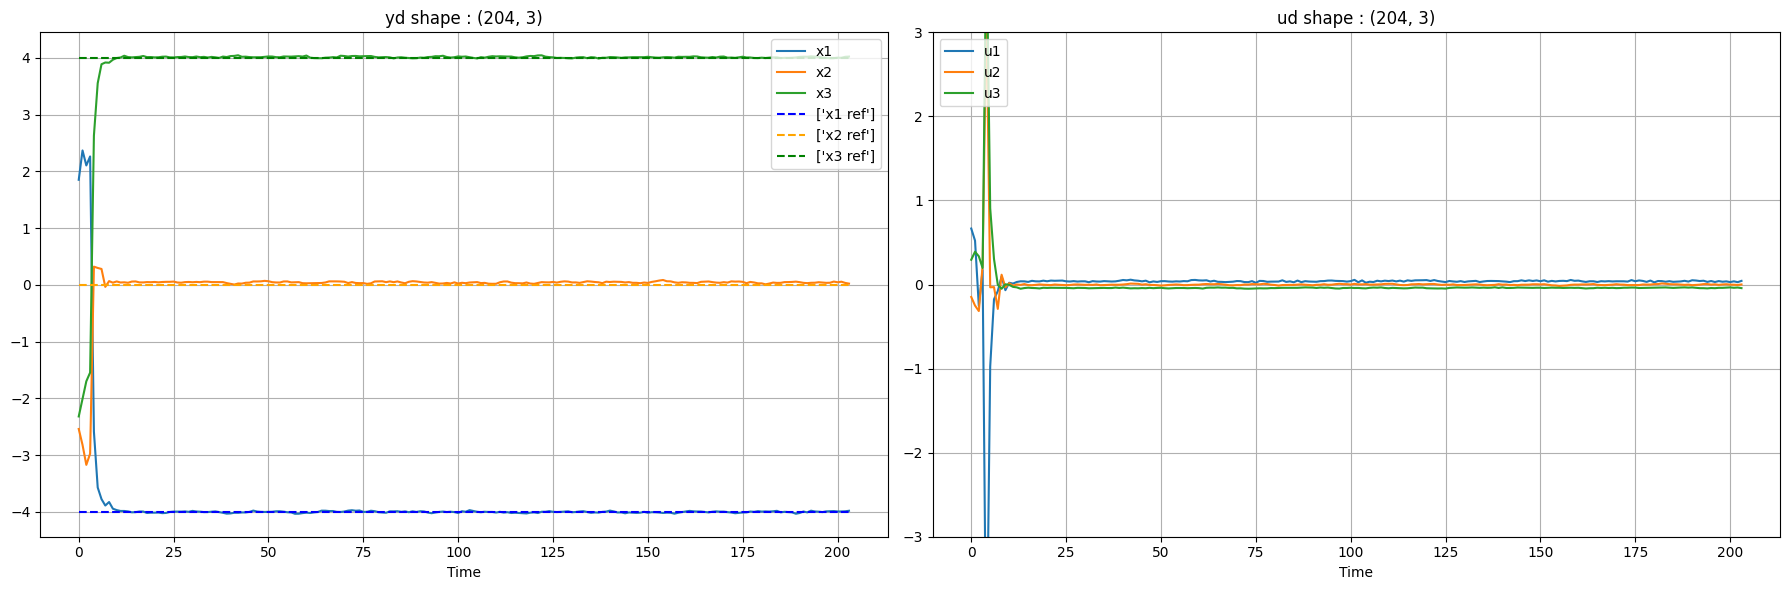

[[-3.98944465  0.03440691  4.01840382]
 [-3.98033205  0.02231856  4.02259766]]
[[ 0.04345211  0.00067309 -0.04273622]]


In [1609]:
plt.rcParams["figure.figsize"] = (18,6)
yT, uT = np.array(yT), np.array(uT)

yT = yT.reshape((T+Tini,3))
uT = uT.reshape((T+Tini,3))
plt.subplot(1,2,1)
plt.plot(range(0,T+Tini), yT, label=['x1', 'x2', 'x3'])
plt.plot(range(0,T+Tini), ref[0]*np.ones(T+Tini), 'b--',label=['x1 ref'])
plt.plot(range(0,T+Tini), ref[1]*np.zeros(T+Tini), '--', color='orange', label=['x2 ref'])
plt.plot(range(0,T+Tini), ref[2]*np.ones(T+Tini), 'g--', label=['x3 ref'])
# plt.plot(range(0,3), )
plt.legend(loc="upper right")
plt.xlabel('Time')
plt.title(f"yd shape : {yT.shape}")
plt.grid('on')
# plt.ylim(-10.5,10.5)
plt.tight_layout()

plt.subplot(1,2,2)
plt.plot(range(0,T+Tini), uT, label=['u1', 'u2', 'u3'])
plt.legend(loc="upper left")
plt.xlabel('Time')
plt.title(f"ud shape : {uT.shape}")
plt.grid('on')
plt.ylim(-3,3)
plt.tight_layout()

plt.show()

print(yT[-2:,:])
print(uT[-1:,:])